In [32]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram
from PIL import Image
import tensorflow as tf
import mido
import subprocess
import random
import os
from scipy.signal import spectrogram, butter, filtfilt


# MIDI to WAV


def convert(filename, soundfont_path):
    # Paths
    midi_file_path = "MIDIs/" + filename + ".mid"
    # soundfont_path = 'FluidR3_GM.sf2'
    output_wav_path = "WAVs/" + filename + ".wav"

    # FluidSynth command
    command = [
        "fluidsynth",
        "-ni",
        soundfont_path,
        midi_file_path,
        "-F",
        output_wav_path,
        "-r",
        "44100",
    ]

    # Run the FluidSynth command
    result = subprocess.run(command, capture_output=True, text=True)

    # Check result
    if result.returncode == 0:
        # print("MIDI has been successfully converted to WAV.")
        pass
    else:
        print("Error converting MIDI to WAV:")
        print(result.stderr)


# ---WAV PROCESSING---

def bandpass_filter(data, lowcut, highcut, sample_rate, order=5):
    nyquist = 0.5 * sample_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Wave file path -> slices of amplitudes
def create_amplitude_tensors(filename, bpm=120):
    wav_file = "WAVs/" + filename + ".wav"

    # Load the WAV file
    sample_rate, data = wavfile.read(wav_file)

    # If stereo, convert to mono by averaging the channels
    if len(data.shape) == 2:
        data = data.mean(axis=1)

    # Apply the band-pass filter
    lowcut = 70  # E2 frequency in Hz
    highcut = 1700  # E6 frequency in Hz
    data = bandpass_filter(data, lowcut, highcut, sample_rate)

    # Calculate the spectrogram with a larger FFT window size
    nperseg = 4094  # Larger window size for better frequency resolution
    noverlap = nperseg // 1.5 #Strange grey bars appear for values greater than 1.5

    frequencies, times, Sxx = spectrogram(data, fs=sample_rate, window='hann', nperseg=nperseg, noverlap=noverlap)

    # Convert the spectrogram (power spectral density) to decibels
    Sxx_dB = 10 * np.log10(Sxx + 1e-10)  # Adding a small number to avoid log(0)

    Sxx_dB = Sxx_dB[:][:512]

    # Calculate the duration of a 32nd note in seconds
    beats_per_second = bpm / 60
    seconds_per_beat = 1 / beats_per_second
    seconds_per_32nd_note = seconds_per_beat / 8  # 32nd note duration

    # Determine the number of time slices for each 32nd note duration
    num_slices = int(np.ceil(times[-1] / seconds_per_32nd_note))

    # List to store the average values of each vertical slice
    avg_slices = []

    # Iterate over each 32nd note slice
    for I in range(num_slices):
        # Determine the start and end time for this slice
        start_time = I * seconds_per_32nd_note
        end_time = (I + 1) * seconds_per_32nd_note

        # Find the indices in the time array that correspond to this slice
        start_idx = np.searchsorted(times, start_time)
        end_idx = np.searchsorted(times, end_time)

        # Get the slice of the spectrogram for this time period
        slice_Sxx_dB = Sxx_dB[:, start_idx:end_idx]

        # Calculate the average value of each vertical pixel in this slice
        avg_values = np.mean(slice_Sxx_dB, axis=1)
        avg_slices.append(avg_values)

    # Convert the list of average slices to a numpy array for further processing
    avg_slices_array = np.array(avg_slices)

    return avg_slices_array


# ---MIDI PROCESSING---


# MIDI file -> file content
def load_midi(file_path):
    """Load the MIDI file and return the messages with their cumulative times."""
    midi_file = mido.MidiFile(file_path)
    messages_with_time = []

    # Initialize the current time
    current_time = 0

    for message in midi_file:
        # Increment the current time by the time of the current message
        current_time += message.time
        # Append the message with the cumulative time to the list
        messages_with_time.append((current_time, message))

    return messages_with_time


# file content -> notes and lengths array
def get_note_periods(messages_with_time):
    """Get the time periods for each note."""
    note_periods = []
    notes_on = {}

    for time, message in messages_with_time:
        if message.type == "note_on" and message.velocity > 0:
            if message.note not in notes_on:
                notes_on[message.note] = []
            notes_on[message.note].append(time)
        elif message.type == "note_off" or (
            message.type == "note_on" and message.velocity == 0
        ):
            if message.note in notes_on and notes_on[message.note]:
                start_time = notes_on[message.note].pop()
                note_periods.append((message.note, start_time, time))

    # If there are notes that were not turned off, handle them appropriately
    for note, times in notes_on.items():
        for start_time in times:
            note_periods.append((note, start_time, messages_with_time[-1][0]))

    return note_periods


# notes and lengths array -> dictionary
def create_note_dict(note_periods):
    """Create a dictionary of note periods."""
    note_dict = {}
    note_id = 0

    for note, start_time, end_time in note_periods:
        note_dict[note_id] = [note, (start_time, end_time)]
        note_id += 1

    return note_dict


# dictionary value -> one-hot encoded array
def get_notes_in_32nd_period(note_dict, start_time, end_time):
    """Get one-hot encoded notes for a specific 32nd-note period."""
    notes_playing = set()
    period_duration = end_time - start_time
    threshold = period_duration / 2

    for note_info in note_dict.values():
        note, (note_start, note_end) = note_info
        overlap_start = max(note_start, start_time)
        overlap_end = min(note_end, end_time)
        overlap_duration = overlap_end - overlap_start

        if overlap_duration > threshold:
            notes_playing.add(note)

    # Create a one-hot encoded array for notes 40 to 88
    one_hot_array = [0] * (88 - 40 + 1)
    for note in notes_playing:
        if 40 <= note <= 88:
            one_hot_array[note - 40] = 1

    return one_hot_array


# dictionary -> note arrays
def get_all_32nd_note_periods(note_dict, start_time, end_time, period_duration):
    """Generate one-hot encoded arrays for all 32nd-note periods."""
    current_time = start_time
    periods = []

    while current_time < end_time:
        next_time = current_time + period_duration
        one_hot_array = get_notes_in_32nd_period(note_dict, current_time, next_time)
        periods.append(one_hot_array)
        current_time = next_time

    return periods


# MIDI file path -> note arrays
def create_midi_tensors(filename):
    """Main function to load the MIDI file and get one-hot encoded note periods."""

    file_path = "MIDIs/" + filename + ".mid"
    messages_with_time = load_midi(file_path)
    note_periods = get_note_periods(messages_with_time)
    note_dict = create_note_dict(note_periods)

    one_hot_encoded_periods = get_all_32nd_note_periods(note_dict, 0, 8, 0.0625)

    one_hot_encoded_periods = np.array(one_hot_encoded_periods).astype(np.uint8)
    # print(one_hot_encoded_periods[0])

    image = Image.fromarray(
        one_hot_encoded_periods.T[::-1] * 255
    )  # Transpose to match desired format
    image.save("OutputImages/" + filename + "_midi.png")

    return one_hot_encoded_periods


# Filename -> predictions
def process_wav_file_for_prediction(model, filename):
    # Generate spectrogram slices
    spectrogram_slices = create_amplitude_tensors(filename, 120)

    # Reshape the slices for the model (add channel dimension)
    spectrogram_slices = spectrogram_slices.reshape(
        (spectrogram_slices.shape[0], spectrogram_slices.shape[1], 1)
    )

    # Predict using the model
    predictions = model.predict(spectrogram_slices, verbose=0)

    return predictions


# Helper function to create moving window slices
def create_windows(data, window_size):
    num_samples, width = data.shape
    windows = []
    for i in range(num_samples - window_size + 1):
        window = data[i : i + window_size]
        windows.append(window.flatten())
    return np.array(windows)

def create_windows_data(input_images, output_images, window_size=10):
    inputs = []
    outputs = []
    for i in range(len(input_images)):
        input_data = input_images[i]
        output_data = output_images[i]

        input_windows = create_windows(input_data, window_size)
        output_windows = create_windows(output_data, window_size)

        inputs.append(input_windows)
        outputs.append(output_windows)

    return inputs, outputs

def create_data(model_path):
    model = tf.keras.models.load_model(model_path)
    MIDI_filenames = [f[:-4] for f in os.listdir("MIDIs/") if f.endswith(".mid")]

    input_images = []
    output_images = []
    for filename in MIDI_filenames:
        # Random file from SoundFonts/
        soundfont_path = os.path.join(
            "D:\Firefox Downloads\Guitar Project\SoundFonts", random.choice(os.listdir("SoundFonts"))
        ) 

        # Assuming convert is a function that takes filename and soundfont_path
        convert(filename, soundfont_path)

        # Process the WAV file for prediction
        predictions = process_wav_file_for_prediction(model, filename)

        # Create MIDI tensors
        notes = create_midi_tensors(filename)

        input_images.append(predictions)
        output_images.append(notes)

        # Delete WAVs/filename.wav
        wav_file_path = os.path.join("WAVs", f"{filename}.wav")
        if os.path.exists(wav_file_path):
            os.remove(wav_file_path)

    return create_windows_data(input_images, output_images)

In [33]:
inputs, outputs = create_data("D:\Firefox Downloads\Guitar Project\saved_tf_models\BasicConvGuitarNotePredictor(512_input).keras")

In [34]:
print([arr.shape for arr in [a[:124] for a in inputs]])
print([arr.shape for arr in outputs])

[(124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (124, 490), (12

In [40]:
import string

def create_tfrecord(inputs, outputs):

    random_letters = "".join([random.choice(string.ascii_lowercase) for _ in range(20)])

    tfrecord_filename = "tfrecords/"+random_letters+".tfrecord"
    # Ensure inputs and outputs have the same length
    # print(len(inputs), len(outputs))
    assert len(inputs) == len(outputs), "Inputs and outputs must have the same length."

    with tf.io.TFRecordWriter(tfrecord_filename) as writer:
        for input_array, output_array in zip(inputs, outputs):
            # Convert the input and output arrays to a feature
            feature = {
                "input": tf.train.Feature(
                    float_list=tf.train.FloatList(value=input_array)
                ),
                "output": tf.train.Feature(
                    int64_list=tf.train.Int64List(value=output_array)
                ),
            }
            # Create an example protocol buffer
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            # Serialize the example to string and write to the file
            writer.write(example.SerializeToString())

for input, output in zip([a[:119] for a in inputs], outputs):
    create_tfrecord(input, output)


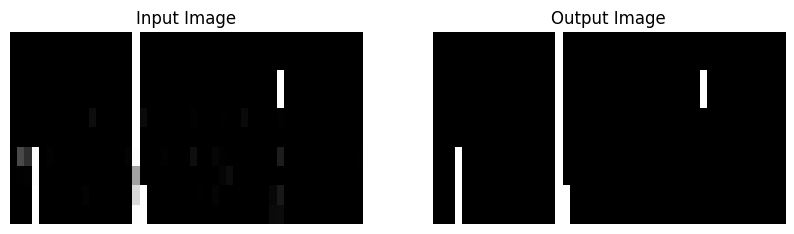

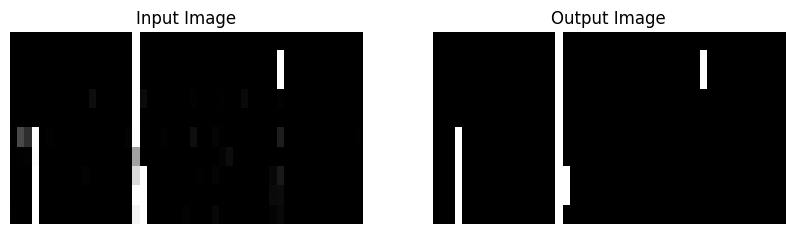

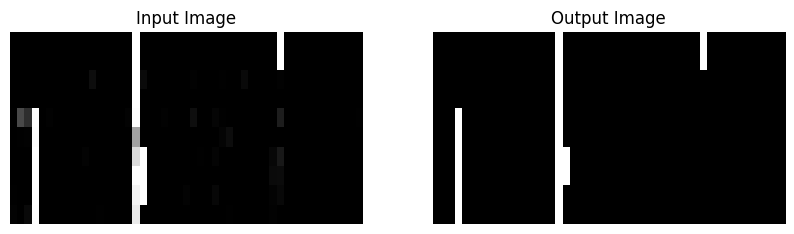

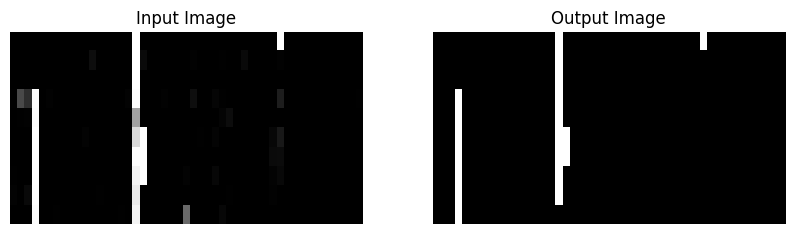

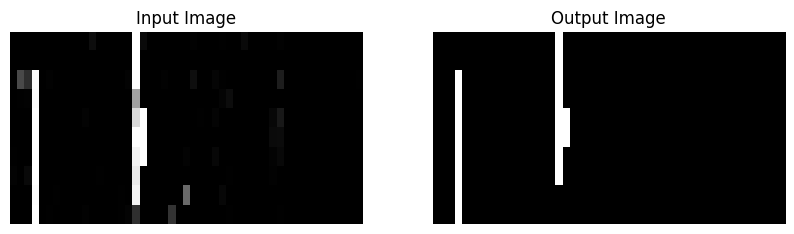

In [44]:
import tensorflow as tf
import matplotlib.pyplot as plt

def parse_example(example_proto):
    feature_description = {
        'input': tf.io.FixedLenFeature([490], tf.float32),
        'output': tf.io.FixedLenFeature([490], tf.int64),
    }
    try:
        return tf.io.parse_single_example(example_proto, feature_description)
    except Exception as e:
        print(f"Error parsing example: {e}")
        return None

def read_and_print_first_datapoint(tfrecord_filename):
    # Create a TFRecordDataset
    raw_dataset = tf.data.TFRecordDataset(tfrecord_filename)
    
    # Parse the raw dataset
    parsed_dataset = raw_dataset.map(parse_example)
    # print(parsed_dataset)
    
    i = 0
    # Take the first element
    for parsed_record in parsed_dataset:
        if parsed_record is None:
            print("Failed to parse the first record.")
            return
        
        input_array = np.asarray(parsed_record['input'])
        output_array = np.asarray(parsed_record['output'])

        # print(input_array.tolist())
        
        # Reshape the arrays to 5x49
        input_image  = input_array.reshape((10, 49))
        output_image  = output_array.reshape((10, 49))
        
        fig, axes = plt.subplots(1, 2, figsize=(10, 2.5))
        
        # Plot input image
        axes[0].imshow(input_image, cmap='gray', aspect='auto')
        axes[0].set_title('Input Image')
        axes[0].axis('off')
        
        # Plot output image
        axes[1].imshow(output_image, cmap='gray', aspect='auto')
        axes[1].set_title('Output Image')
        axes[1].axis('off')
        
        plt.show()
        i += 1
        
        if i > 4:
            break

# Example usage
tfrecord_filename = "tfrecords/aabrgwsklbgiezrvnfqw.tfrecord"
read_and_print_first_datapoint(tfrecord_filename)


In [3]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, BatchNormalization, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam


def prepare_data():
    # Parsing function
    def _parse_function(proto):
        keys_to_features = {
            'input': tf.io.FixedLenFeature([490], tf.float32),
            'output': tf.io.FixedLenFeature([490], tf.int64),
        }
        parsed_features = tf.io.parse_single_example(proto, keys_to_features)
        predicted_values = parsed_features['input']
        real_values = parsed_features['output']
        return predicted_values, real_values

    # Convert tfrecord files to glorified numpy arrays
    tfrecord_dir = 'tfrecords'
    tfrecord_files = [os.path.join(tfrecord_dir, f) for f in os.listdir(tfrecord_dir) if f.endswith('.tfrecord')]
    raw_dataset = tf.data.TFRecordDataset(tfrecord_files)
    parsed_dataset = raw_dataset.map(_parse_function)

    batch_size = 32
    dataset = parsed_dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    # Split into training and validation datasets
    dataset_size = sum(1 for _ in dataset)
    train_size = int(0.8 * dataset_size)
    val_size = dataset_size - train_size

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)

    return train_dataset, val_dataset

input_windows, output_windows = prepare_data()

# Assuming input_data and target_data are your input and corresponding binary arrays
# input_data.shape -> (num_samples, 49)
# target_data.shape -> (num_samples, 49)

window_size = 10

# Define the model
model = Sequential([
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    
    Dense(128, activation='relu', input_shape=(window_size * 49,)),
    Dense(64, activation='relu'),
    Dense(window_size * 49, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(input_windows, validation_data=output_windows, epochs=40, batch_size=32, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])


ValueError: `y` argument is not supported when using dataset as input.

In [ ]:
model_save_path = 'saved_tf_models/DataCleaner(WindowSize10).keras'

# Save the model
model.save(model_save_path)

In [ ]:
# Prediction and aggregation
def predict_and_aggregate(model, data, window_size, threshold=0.5):
    num_samples, width = data.shape
    predictions = np.zeros((num_samples, width))
    counts = np.zeros((num_samples, width))

    for i in range(num_samples - window_size + 1):
        window = data[i:i+window_size].flatten().reshape(1, -1)
        pred = model.predict(window)
        pred = pred.reshape(window_size, width)
        predictions[i:i+window_size] += pred
        counts[i:i+window_size] += 1

    averaged_predictions = predictions / counts
    final_predictions = (averaged_predictions >= threshold).astype(int)
    return final_predictions

# Generate final output array
# final_output = predict_and_aggregate(model, input_data, window_size)